In [1]:
import sys
sys.path.append("../.")

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from gnn_powergrid.dataset import prepare_dataset

## Prepare the dataset

In [3]:
env_name = "l2rpn_case14_sandbox"

path = pathlib.Path().resolve().parent
BENCH_CONFIG_PATH = path / "configs" / (env_name + ".ini")
DATA_PATH = path / "Datasets" / env_name / "DC"
LOG_PATH = path / "lips_logs.log"

benchmark = PowerGridBenchmark(benchmark_path=DATA_PATH,
                               benchmark_name="Benchmark4",#"DoNothing",
                               load_data_set=True,
                               config_path=BENCH_CONFIG_PATH,
                               log_path=LOG_PATH)

In [4]:
print(benchmark.train_dataset.size)
print(benchmark._test_dataset.size)

100000
10000


In [ ]:
device = torch.device("cuda:0") # or "cuda:0" if you have any GPU
train_loader, val_loader, test_loader, test_ood_loader = prepare_dataset(benchmark=benchmark, 
                                                                         batch_size=128, 
                                                                         device=device)

In [6]:
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[3584, 2], edge_index=[2, 6742], edge_attr=[6742], y=[3584, 1], edge_index_no_diag=[2, 4950], edge_attr_no_diag=[4950], ybus=[3584, 28], batch=[3584], ptr=[129])


## Use a GNN model without Neural Network

In [11]:
from gnn_powergrid.gnn.models.gnn_wo_nn import GPGmodel_without_NN

gpg_model_wo_nn = GPGmodel_without_NN(ref_node=0, num_gnn_layers=100, device=device)
gpg_model_wo_nn.to(device)

GPGmodel_without_NN(
  (input_layer): GPGinput_without_NN()
  (lc_layer): LocalConservationLayer()
  (inter_layers): ModuleList(
    (0-99): 100 x GPGintermediate()
  )
)

## Optimization over test dataset

In [12]:
predictions_list = []
observations_list = []
error_per_batch = []
for batch in test_loader:
    out, errors = gpg_model_wo_nn(batch)
    predictions_list.append(out)
    observations_list.append(batch.y)
    #error_per_batch.append(torch.mean(torch.vstack(errors)))
    error_per_batch.append([float(error.detach().cpu().numpy()) for error in errors])
observations = torch.vstack(observations_list)
predictions = torch.vstack(predictions_list)
#errors = np.vstack([error.cpu().numpy() for error in error_per_batch])
errors = np.vstack(error_per_batch)
errors = errors.mean(axis=0)

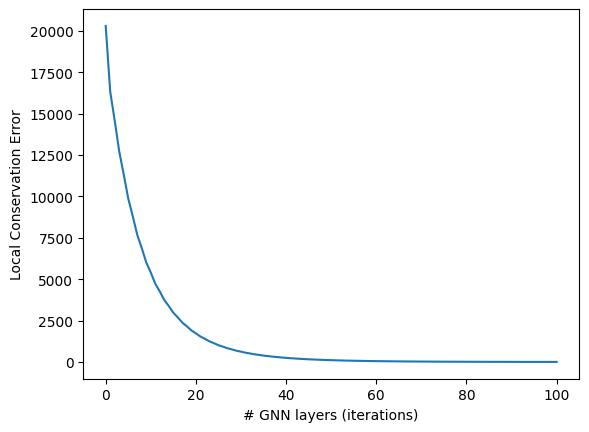

In [13]:
plt.figure()
plt.plot(errors)
plt.xlabel("# GNN layers (iterations)")
plt.ylabel("Local Conservation Error")
plt.show()

## Evaluate using LIPS

In [14]:
from gnn_powergrid.evaluation.evaluate_gnn import evaluate_gnn

In [ ]:
metrics = evaluate_gnn(benchmark, thetas_pred=predictions, thetas_obs=observations, dataset="test")

In [16]:
metrics

{'theta': {'MAPE10': 0.00014270937518711036},
 'power': {'ML': {'MSE_avg': {'p_or': 0.0003162410866934806,
    'p_ex': 0.0003162410866934806},
   'MAE_avg': {'p_or': 0.003286101622506976, 'p_ex': 0.003286101622506976},
   'MAPE_avg': {'p_or': 37924061184.0, 'p_ex': 37924061184.0},
   'MAPE_90_avg': {'p_or': 0.0005704067365017166,
    'p_ex': 0.0005704067365017166},
   'MAPE_10_avg': {'p_or': 0.00023004051043067157,
    'p_ex': 0.00023004051043067157}},
  'Physics': {'LOSS_POS': {'violation_proportion': 0.0},
   'DISC_LINES': {'p_or': 0.0, 'p_ex': 0.0, 'violation_proportion': 0.0},
   'CHECK_LOSS': {'violation_percentage': 0.0},
   'CHECK_GC': {'violation_percentage': 0.0,
    'mae': 1.0942078e-05,
    'wmape': 1.0},
   'CHECK_LC': {'violation_percentage': 5.282857142857143,
    'mae': 0.00227231553578342,
    'mape': 0.00010876059506515019}}}}

### Optimization over OOD dataset

In [17]:
predictions_list = []
observations_list = []
error_per_batch = []
for batch in test_ood_loader:
    out, errors = gpg_model_wo_nn(batch)
    predictions_list.append(out)
    observations_list.append(batch.y)
    #error_per_batch.append(torch.mean(torch.vstack(errors)))
    error_per_batch.append([float(error.detach().cpu().numpy()) for error in errors])
observations = torch.vstack(observations_list)
predictions = torch.vstack(predictions_list)
#errors = np.vstack([error.cpu().numpy() for error in error_per_batch])
errors = np.vstack(error_per_batch)
errors = errors.mean(axis=0)

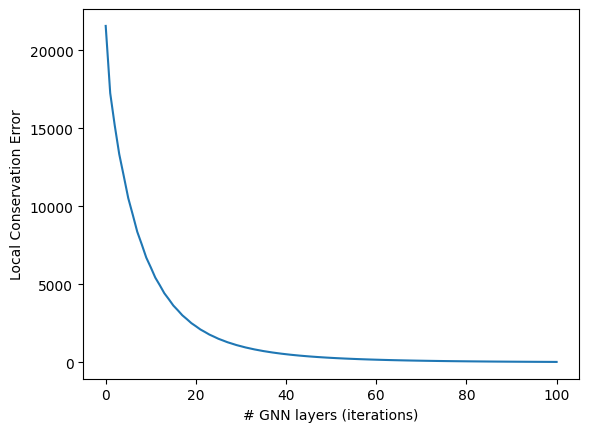

In [18]:
plt.figure()
plt.plot(errors)
plt.xlabel("# GNN layers (iterations)")
plt.ylabel("Local Conservation Error")
plt.show()

In [ ]:
metrics = evaluate_gnn(benchmark, thetas_pred=predictions, thetas_obs=observations, dataset="ood")

In [20]:
metrics

{'theta': {'MAPE10': 0.001213375357409322},
 'power': {'ML': {'MSE_avg': {'p_or': 0.03379491716623306,
    'p_ex': 0.03379491716623306},
   'MAE_avg': {'p_or': 0.02671099454164505, 'p_ex': 0.02671099454164505},
   'MAPE_avg': {'p_or': 851679313920.0, 'p_ex': 851679313920.0},
   'MAPE_90_avg': {'p_or': 0.003704068357133048, 'p_ex': 0.003704068357133048},
   'MAPE_10_avg': {'p_or': 0.002151612947098229,
    'p_ex': 0.002151612947098229}},
  'Physics': {'LOSS_POS': {'violation_proportion': 0.0},
   'DISC_LINES': {'p_or': 0.0, 'p_ex': 0.0, 'violation_proportion': 0.0},
   'CHECK_LOSS': {'violation_percentage': 0.0},
   'CHECK_GC': {'violation_percentage': 0.0,
    'mae': 1.09466555e-05,
    'wmape': 1.0},
   'CHECK_LC': {'violation_percentage': 15.512142857142857,
    'mae': 0.019131971869699706,
    'mape': 0.0009098523926832468}}}}